In [3]:
import sys
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pygsp.graphs import Graph

# For unrolling
import networkx as nx
sys.path.insert(0, './GUN')

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

DATASET_PATH = './dataset/SP500/SP500_GMRF_6sectors_sparser.npy'
MAX_SIGNALS = 10  # 25
SEED = 0
PATH = './results/real_data/'

plt.rcParams['image.cmap'] = 'Spectral_r'

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


## Auxiliary functions

In [4]:
def get_best_err(err):
    mean_err = np.mean(err, axis=1)
    std = np.std(err, axis=1)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    best_std = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
            best_std[i, j] = std[i, j, best_epochs_mean[i, j]]

    return best_mean_err, best_std, best_epochs_mean,

def print_err(err, std, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f} +- {:.4f}'.format(err[i, j], std[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs

## Load dataset

Number of nodes: 189
Mean Smoothness: 0.073


Text(0.5, 1.0, 'Original graph')

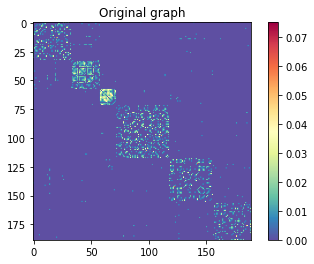

In [5]:
data = np.load(DATASET_PATH, allow_pickle=True).item()
X = data['X']
n_signals = np.min([X.shape[1], MAX_SIGNALS])

A = data['A']
L = np.diag(np.sum(A, axis=0)) - A
S = A
print('Number of nodes:', A.shape[0])

X_norm = (X - np.mean(X, axis=0))/np.std(X, axis=0)
sm_norm = np.trace((X.T@L@X)/np.linalg.norm(X, axis=0)**2)/X.shape[1]
idx = np.argsort(np.diag(X_norm.T@L@X_norm))
X = X[:,idx]
print('Mean Smoothness: {:.3f}'.format(sm_norm))

G = Graph(A)
G.set_coordinates()

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.title('Original graph')




## Set the expetiments

In [8]:
N_P = [.3]

# Model parameters
epochs =  500
lr = .001
loss = nn.MSELoss

Exps = [
        # {'type': 'BL', 'S': A, 'alpha': .75, 'legend': 'BL'},
        # {'type': 'TV', 'A': A, 'alpha': 2, 'legend': 'TV'},
        # {'type': 'LR', 'L': L, 'alpha': 1, 'legend': 'LR'},
        # {'type': 'GTF', 'A': A, 'k': 3, 'lamb': 3, 'legend': 'GTF'},

        # {'type': 'MED', 'S': A, 'legend': 'MED'},
        # {'type': 'GCNN', 'fts': 80, 'A': A, 'last_fts': 1, 'last_act': None,
        #  'n_convs': 2, 'n_lin': 1, 'loss': loss(reduction='none'), 'legend': 'GCNN'},
        # {'type': 'GAT', 'fts': 50, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': None,
        #  'loss': loss(reduction='none'), 'legend': 'GAT'},
        # {'type': 'KronAE', 'fts': 20, 'A': A, 'r': .8, 'last_act': None,
        #  'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # OURS
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [60]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.1, .9], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*5, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.2, .8], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [50, 100, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5,
         'loss': loss(reduction='none'), 'legend': 'GD'},

         {'type': 'UNROLLING', 'arch': 'GUSC', 'fts': 64, 'dropout': 0, 'legend': 'GUSC'},
         {'type': 'UNROLLING', 'arch': 'GUSC_2', 'fts': 50, 'dropout': 0, 'legend': 'GUSC_2'},

         {'type': 'UNROLLING', 'arch': 'GUTF', 'fts': 64, 'dropout': 0, 'legend': 'GUTF'},
         {'type': 'UNROLLING', 'arch': 'GUTF_2', 'fts': 50, 'dropout': 0, 'legend': 'GUTF_2'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Compute needed matrices
for exp in Exps:
    if exp['type'] == 'DD' and exp['legend'] == 'GD':
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='ward')
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As

    elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
        H = utils.create_filter(S, exp['h_params'])
        exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
        exp['As'] = []
    elif exp['type'] == 'UNROLLING':
        G_nx = nx.from_numpy_array(S) 
        adj = nx.adjacency_matrix(G_nx, nodelist=sorted(G_nx.nodes)).astype(float)
        exp['adj'] = utils.to_torch_sparse(adj.astype(np.float32)) 
        if 'GUTF' in exp['arch']:
            G_nx = nx.from_numpy_array(np.sqrt(A))
            Delta = nx.linalg.graphmatrix.incidence_matrix(G_nx).todense().T
            exp['Delta'] = torch.Tensor(Delta).to(device)
        else:
            exp['Delta'] = None


### Denoising - Gaussian noise

In [9]:
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x = X[:, j]
        x /= np.linalg.norm(x)
        x_n = ds.GraphSignal.add_noise(x, n_p, n_type='gaussian')

        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                if 'adj' in exp.keys():
                    x_n_tensor = torch.Tensor(x_n).reshape((x_n.size, 1))
                    _, err[i, j, k], _ = model.fit(x_n_tensor, x, device=device, adj_list=exp['adj'])
                else:
                    _, err[i, j, k], _ = model.fit(x_n, x, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)

            err[i, j, k] = err[i, j, k]/np.linalg.norm(x,2)**2
        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.3


AttributeError: 'GUSC' object has no attribute 'input'

### Plot results

In [ ]:
best_mean_err, std, _ = get_best_err(err)
print_err(best_mean_err, std, weights)

N_P: [0.3]
BL (0.0): 	0.3562 +- 0.1306
TV (0.0): 	0.2397 +- 0.0938
LR (0.0): 	0.2365 +- 0.0317
GTF (0.0): 	0.2419 +- 0.0955
MED (0.0): 	0.3288 +- 0.2305
GCNN (6721.0): 	0.2509 +- 0.0627
GAT (8501.0): 	0.2029 +- 0.0657
K-GAE (901.0): 	0.3509 +- 0.2273
GCG (7260.0): 	0.1908 +- 0.0496
GCG (7550.0): 	0.2067 +- 0.0710
GD (7550.0): 	0.1968 +- 0.0494


### Denoising - Uniform noise

In [7]:
N_P = [.3**2, .3]

# Model parameters
epochs =  500
lr = .001
loss = nn.MSELoss

Exps = [
        # {'type': 'BL', 'S': A, 'alpha': .75, 'legend': 'BL'},
        # {'type': 'TV', 'A': A, 'alpha': 2, 'legend': 'TV'},
        # {'type': 'LR', 'L': L, 'alpha': 1, 'legend': 'LR'},
        # {'type': 'GTF', 'A': A, 'k': 3, 'lamb': 3, 'legend': 'GTF'},

        # {'type': 'MED', 'S': A, 'legend': 'MED'},
        # {'type': 'GCNN', 'fts': 80, 'A': A, 'last_fts': 1, 'last_act': None,
        #  'n_convs': 2, 'n_lin': 1, 'loss': loss(reduction='none'), 'legend': 'GCNN'},
        # {'type': 'GAT', 'fts': 50, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': None,
        #  'loss': loss(reduction='none'), 'legend': 'GAT'},
        # {'type': 'KronAE', 'fts': 20, 'A': A, 'r': .8, 'last_act': None,
        #  'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # OURS
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [60]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.1, .9], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*5, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.2, .8], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [50, 100, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .5,
         'loss': loss(reduction='none'), 'legend': 'GD'},

        {'type': 'UNROLLING', 'arch': 'GUSC', 'fts': 64, 'dropout': 0, 'legend': 'GUSC'},
        {'type': 'UNROLLING', 'arch': 'GUSC_2', 'fts': 50, 'dropout': 0, 'legend': 'GUSC_2'},

        {'type': 'UNROLLING', 'arch': 'GUTF', 'fts': 64, 'dropout': 0, 'legend': 'GUTF'},
        {'type': 'UNROLLING', 'arch': 'GUTF_2', 'fts': 50, 'dropout': 0, 'legend': 'GUTF_2'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Compute needed matrices
for exp in Exps:
    if exp['type'] == 'DD' and exp['legend'] == 'GD':
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='ward')
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As

    elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
        H = utils.create_filter(S, exp['h_params'])
        exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
        exp['As'] = []


In [8]:
err2 = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x = X[:, j]
        x /= np.linalg.norm(x)
        x_n = ds.GraphSignal.add_noise(x, n_p, n_type='uniform')

        noise_err = np.linalg.norm(x-x_n)**2

        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                _, err2[i, j, k], _ = model.fit(x_n, x=x, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err2[i, j, k] = np.repeat(err_non_train, epochs)

            err2[i, j, k] = err2[i, j, k]/np.linalg.norm(x,2)**2
        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.09
0 (noise_err: 0.090) 1 (noise_err: 0.090) 2 (noise_err: 0.090) 3 (noise_err: 0.090) 4 (noise_err: 0.090) 5 (noise_err: 0.090) 6 (noise_err: 0.090) 7 (noise_err: 0.090) 8 (noise_err: 0.090) 9 (noise_err: 0.090) 10 (noise_err: 0.090) 11 (noise_err: 0.090) 12 (noise_err: 0.090) 13 (noise_err: 0.090) 14 (noise_err: 0.090) 15 (noise_err: 0.090) 16 (noise_err: 0.090) 17 (noise_err: 0.090) 18 (noise_err: 0.090) 19 (noise_err: 0.090) 20 (noise_err: 0.090) 21 (noise_err: 0.090) 22 (noise_err: 0.090) 23 (noise_err: 0.090) 24 (noise_err: 0.090) 
Noise: 0.3
0 (noise_err: 0.300) 1 (noise_err: 0.300) 2 (noise_err: 0.300) 3 (noise_err: 0.300) 4 (noise_err: 0.300) 5 (noise_err: 0.300) 6 (noise_err: 0.300) 7 (noise_err: 0.300) 8 (noise_err: 0.300) 9 (noise_err: 0.300) 10 (noise_err: 0.300) 11 (noise_err: 0.300) 12 (noise_err: 0.300) 13 (noise_err: 0.300) 14 (noise_err: 0.300) 15 (noise_err: 0.300) 16 (noise_err: 0.300) 17 (noise_err: 0.300) 18 (noise_err: 0.300) 19 (noise_err: 0.300) 20 (no

### Plot results

N_P: [0.09, 0.3]
BL (0.0): 	0.2160 +- 0.1284	0.4057 +- 0.1283
TV (0.0): 	0.2468 +- 0.0927	0.3554 +- 0.1103
LR (0.0): 	0.0882 +- 0.0017	0.2872 +- 0.0027
GTF (0.0): 	0.2975 +- 0.0960	0.4594 +- 0.0947
MED (0.0): 	0.3401 +- 0.2279	0.5083 +- 0.2337
GCNN (6721.0): 	0.0908 +- 0.0041	0.2904 +- 0.0048
GAT (8501.0): 	0.2229 +- 0.0773	0.3851 +- 0.0740
K-GAE (901.0): 	0.2704 +- 0.2208	0.4545 +- 0.2167
GCG (7260.0): 	0.1236 +- 0.0809	0.3315 +- 0.0754
GCG (7550.0): 	0.0920 +- 0.0072	0.3006 +- 0.0065
GD (7550.0): 	0.1346 +- 0.0257	0.3178 +- 0.0346
(2, 25, 11, 500)


[<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

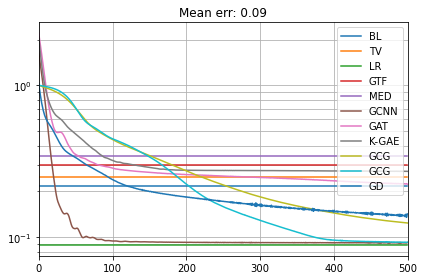

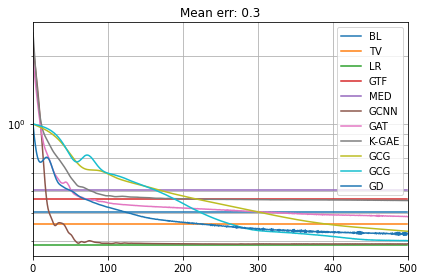

In [15]:
best_mean_err, std, _ = get_best_err(err2)
print_err(best_mean_err, std, weights)

plot_iter_err(np.mean(err2, axis=1), 'Mean err')

In [10]:
# # Save data
# data = {
#     'seed': SEED,
#     'X': X,
#     'A': A,
#     'N_P': N_P,
#     'exps': Exps,
#     'err': err,
#     'err2': err2,
#     'lr': lr,
#     'weights': weights,
#     'legend': legend,
#     'fmts': [],
# }
# utils.save_results('sp500', PATH, data)

In [11]:
plt.show()